In [1]:
from __future__ import absolute_import
import importlib

from copy import copy

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from types import SimpleNamespace

import matplotlib.pyplot as plt
from models import MLP, OneOverSqr, DualRateModel, ParallelMLP
from dsp_utils import seg_time
from siggen_utils import herzfeld_block
from plt_utils import plot_by_key,plot_segments

from runners import Runner


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
P0=0
Pplus=1
Pminus=-1
Pchannel=np.nan

TfN1 = 100
TfA = 300
TfN2 = 100

TsN=60
TsA=120
TsB=20
TsC=20

# T=300
TaN=150
TaB=120*5

playlist = {
'frogs': [(P0,TfN1),((P0,Pplus),TfA),(P0,TfN2)],
'anti_frogs': [(P0,TfN1),(Pplus,TfA),(P0,TfN2)],
'savings': 2 * [(P0, TsN), (Pplus, TsA), (Pminus, TsB), (Pchannel, TsC)],
'sprecovery': [(P0, 192),
               (Pplus, 384),
               (Pminus, 20),
               (Pchannel, 400)],
'spOVRrecovery': [(P0, 192),
               (Pplus, 1000),
               (Pminus, 20),
               (Pchannel, 400)],
'evrecovery': [(P0, 192),
               (Pplus, 384),
               (Pminus, 20),
               (Pplus, 20),
               (Pchannel, 400)],
'lng_recovery': [(P0, 192),
               (Pplus, 384),
               (Pminus, 384),
               (Pchannel, 400)],
'sprecoverySMITH': [(P0, 120),
               (Pplus, 130),
               (Pminus, 20),
               (Pchannel, 100)],
'spOVRrecoverySMITH': [(P0, 120),
               (Pplus, 600),
               (Pminus, 20),
               (Pchannel, 100)],
'AB0':[(P0, TaN),(Pminus, TaB)],
'AB1':[(P0, TaN),(Pplus,13),(Pminus, TaB)],
'AB2':[(P0, TaN),(Pplus,41),(Pminus, TaB)],
'AB3':[(P0, TaN),(Pplus,112),(Pminus, TaB)],
'AB4':[(P0, TaN),(Pplus,230),(Pminus, TaB)],
'AB5':[(P0, TaN),(Pplus,410),(Pminus, TaB)],
# 'AB5':[(P0, TaN),(Pplus,369),(Pminus, TaB)],
'AB4r':[(P0, TaN),(Pplus/2,230),(Pminus, TaB)],

'ANB0':[(P0, TaN),(Pminus, TaB)],
'ANB1':[(P0, TaN),(Pplus,13),(P0, TaB),(Pminus, TaB)],
'ANB2':[(P0, TaN),(Pplus,41),(P0, TaB),(Pminus, TaB)],
'ANB3':[(P0, TaN),(Pplus,112),(P0, TaB),(Pminus, TaB)],
    }

def generate_herzfeld_scenarios(z_list=None, n_blocks=None, Tflips=None): 
    out_dict = {}
    for z in z_list:
        scenario_name =  f'herzfeld,z={z}'
        pert_per_z = []
        for n in range(n_blocks):
            hz = herzfeld_block(z, P1=Pplus,P2=Pminus,P0=P0, tau=1)
            pert_per_z.append((hz,len(hz)))
        out_dict.update({scenario_name:pert_per_z})
    return out_dict

hrz_params = {'z_list': [0.1,0.5,0.9], 'n_blocks': 25}
playlist.update(generate_herzfeld_scenarios(**hrz_params))
        

In [3]:
frog_playlist = {
f'frogs{f}': [(P0,TfN1),((P0,Pplus),TfA_),(P0,TfN2)] for f,TfA_ in enumerate([300,600, 900])}

frog_playlist_a = {
f'anti_frogs{f}': [(P0,TfN1),(Pplus,TfA_),(P0,TfN2)] for f,TfA_ in enumerate([300,600, 900])} 

frog_playlist.update(frog_playlist_a)

In [4]:
# baseline_settings = {'criterion':'MSE', 'k':[0.1,0,5], 'learning_rate':0.5e-4, 'sigma_noi':0.0, 'tau_u':1}
# baseline_settings = {'criterion':'MSE', 'k':[0.5,0,2], 'learning_rate':0.5e-4, 'sigma_noi':0.0, 'tau_u':1}

w=0.2
dual_rate_settings = {'k':[0,0,1], 'tau_u':1}


# dual_rate_flags = {'apply_initial_state': False, 'save_model_at_init':False, 'model_type': 'numpy'}
dual_rate_flags_runner = {'model_type': 'numpy',
                   'initial_state': [0,0,0], 
                   'save_model_at_init':False, 
                  'do_backprop': False}

# nn_settings = {'criterion':'MSE', 'k':[0.3,0,1], 'learning_rate':0.5e-4, 'sigma_noi':0.0, 'tau_u':1, 'auto_steps':10}
error_nn_setting = {'criterion':'MSE', 'k':[1,1,1,1], 'learning_rate':1e-5/w, 'sigma_noi':0.0, 'tau_u':1,  'enable_combo': True}
combo_nn_setting = {'criterion':'MSE', 'k':[1,1,1,1], 'learning_rate':1e-5/w, 'sigma_noi':0.0, 'tau_u':1,  'enable_combo': True}
error_plus_combo_nn_setting = {'criterion':'MSE', 'k':[1,1,1,1], 'learning_rate':1e-5/w/2, 'sigma_noi':0.0, 'tau_u':1,  'enable_combo': True}


test_vec= np.stack([np.linspace(-10,10,200), 
                    np.zeros(200),
                    np.zeros(200)]).T

In [33]:
w

0.2

In [25]:
dual_rate_flags_model = dict(input_proj_vec=[0,0,1])

model_args_s = {}
# model_args_s['Colman'] = dict(a_f=0.55,a_s=0.995, b_f=0.4, b_s=0.05, 
#                               info={'model_type':'dual_rate','runner_settings':dual_rate_settings}) #approx means from Coltman et al.
model_args_s['Smith'] = dict(a_f=0.59,a_s=0.992, b_f=0.21, b_s=0.02, 
                             info={'model_type':'dual_rate','runner_settings':dual_rate_settings})  #Smith et al

model_construct_args =  dict(n_inputs = 3,
                  n_hidden = 5*4*512,
                  n_outs = 1,
                  en_bias = False,
                 b_high=3, first_layer_init='ones',
                first_layer_weights_trainable = True,
                out_layer_init='zeros',
                  nl = lambda : OneOverSqr(w=w), skip_gain= 0.0)
model_args_s['errorNN'] =  dict(n_inputs = 4,
                      n_hidden = 5*4*512,
                      n_outs = 1,
                      en_bias = False,
                     b_high=3, first_layer_init='ones',
                    first_layer_weights_trainable = True,
                    out_layer_init='zeros',
                        prescaling = [0,0,1,0],         
                      nl = lambda : OneOverSqr(w=w), skip_gain= 0.0, info={'model_type':'mlp','runner_settings':error_nn_setting})

model_args_s['comboNN'] =  dict(n_inputs = 4,
                      n_hidden = 5*4*512,
                      n_outs = 1,
                      en_bias = False,
                     b_high=3, first_layer_init='ones',
                    first_layer_weights_trainable = True,
                    out_layer_init='zeros', prescaling = [0,0,0,1],
                      nl = lambda : OneOverSqr(w=w), skip_gain= 0.0, info={'model_type':'mlp','runner_settings':combo_nn_setting})


model_args_s['errorPlusComboNN'] = dict(n_inputs = 4,
                                        parameter_sets = [model_args_s['errorNN'], model_args_s['comboNN']],
                                    info={'model_type':'parallel_mlp','runner_settings':error_plus_combo_nn_setting})

model_args_s['MoreErrorPlusComboNN'] = dict(n_inputs = 4,
                                        parameter_sets = [{**model_args_s['errorNN'], 'n_hidden' : 5*6*512}, 
                                                          {**model_args_s['comboNN'],  'n_hidden' : 5*2*512}],
                                    info={'model_type':'parallel_mlp','runner_settings':error_plus_combo_nn_setting})

model_args_s['MoreErrorPlusComboNNrepeat'] = dict(n_inputs = 4,
                                        parameter_sets = [{**model_args_s['errorNN'], 'n_hidden' : 5*6*512}, 
                                                          {**model_args_s['comboNN'],  'n_hidden' : 5*2*512}],
                                    info={'model_type':'parallel_mlp','runner_settings':error_plus_combo_nn_setting})

model_args_s['MoreErrorPlusComboNN_v2'] = dict(n_inputs = 4,
                                        parameter_sets = [{**model_args_s['errorNN'],  'main_gain' : 6/4}, 
                                                          {**model_args_s['comboNN'],  'main_gain' : 2/4}],
                                    info={'model_type':'parallel_mlp','runner_settings':error_plus_combo_nn_setting})

In [26]:
# results = {}
# frog_results = {}
tested_settings = {'MoreErrorPlusComboNNrepeat'}  #empty for all{'MoreErrorPlusComboNN'} # {'errorPlusComboNN'}

In [27]:
for setting,model_args  in model_args_s.items():
    if len(tested_settings) > 0 and  setting not in tested_settings:
        print(f'skipping setting "{setting}"')
        continue
    if model_args['info']['model_type'] == 'mlp':
        model_class = MLP
        flags_runner = {}
        flags_model = {}
    elif model_args['info']['model_type'] == 'parallel_mlp':
        model_class = ParallelMLP
        flags_runner = {}
        flags_model = {}
    elif model_args['info']['model_type'] == 'dual_rate':
        model_class = DualRateModel
        flags_runner = dual_rate_flags_runner
        flags_model = dual_rate_flags_model
    else:
        raise ValueError
        
        
#     runner = Runner(model=model_class(**{**model_args, **flags_model}),
#                     test_vec=None,
#                     **{**model_args['info']['runner_settings'],**flags_runner})

            
    runner = Runner(model_class=model_class, model_construct_args={**model_args, **flags_model},
                    test_vec=None,
                    **{**model_args['info']['runner_settings'],**flags_runner})
    
    results[setting] = runner.run_multiple(playlist)
#     frog_results[setting] = runner.run_multiple(frog_playlist)

skipping setting "Smith"
skipping setting "errorNN"
skipping setting "comboNN"
skipping setting "errorPlusComboNN"
skipping setting "MoreErrorPlusComboNN"
model reset
running scenario: frogs
running scenario: anti_frogs
running scenario: savings
running scenario: sprecovery
running scenario: spOVRrecovery
running scenario: evrecovery
running scenario: lng_recovery
running scenario: sprecoverySMITH
running scenario: spOVRrecoverySMITH
running scenario: AB0
running scenario: AB1
running scenario: AB2
running scenario: AB3
running scenario: AB4
running scenario: AB5
running scenario: AB4r
running scenario: ANB0
running scenario: ANB1
running scenario: ANB2
running scenario: ANB3
running scenario: herzfeld,z=0.1
running scenario: herzfeld,z=0.5
running scenario: herzfeld,z=0.9
skipping setting "MoreErrorPlusComboNN_v2"


In [28]:
antero_colors=['tab:red','tab:blue','tab:orange','tab:green']
def do_plots(results,playlist,figsize=(24, 12)):
    plt.figure(figsize=figsize)
    plt.subplot(2,3,1)
    plot_segments(results['savings'].u_lp,
              t_start=playlist['savings'][0][1],
              n_segments=2,
              t_increment=playlist['savings'][0][1]+playlist['savings'][1][1]+playlist['savings'][2][1]+playlist['savings'][3][1],
              t_segment=playlist['savings'][1][1],             
             )
    plt.subplot(2,3,2)
    plot_by_key(results, ['frogs','anti_frogs'],visu_offsets = [0, 0.00])
    plt.xlabel('epochs')
    plt.ylabel('u(epoch) [au]')
    plt.subplot(2,3,3)
    plot_by_key(results,
                ['sprecovery','spOVRrecovery','lng_recovery','evrecovery'],
                colors=['tab:red','tab:blue','tab:orange','tab:green'],
                align_end=True,
                visu_offsets=[0]*10,
               )
    
    plt.subplot(2,3,4)
    plot_by_key(results,
                ['AB0','AB1','AB2','AB3'],
                colors=antero_colors,
                align_end=True,
                visu_offsets=[0]*10,
               )
    
    plt.subplot(2,3,5)
    plot_by_key(results,
                ['ANB0','ANB1','ANB2','ANB3'],
                colors=antero_colors,
                align_end=True,
                visu_offsets=[0]*10,
               )
    
    plt.subplot(2,3,6)
    for iz, z in enumerate(hrz_params['z_list']):
        deltas = []
        scenario = f'herzfeld,z={z}'
        this_result = results[scenario]
        block_length = playlist[scenario]
        pointer = 0
        for bb in range(hrz_params['n_blocks']):
            block_length = playlist[scenario][bb][-1]
            pointer += block_length
            deltas.append(this_result.u_lp[pointer-1]-this_result.u_lp[pointer-3])            

        plt.plot(deltas,'x',label = f'z={z}')
    plt.legend(loc='upper right')
    plt.xlabel('block #')
    plt.ylabel('adaptation delta channel2-channel1')

## Evaluating basic checklist

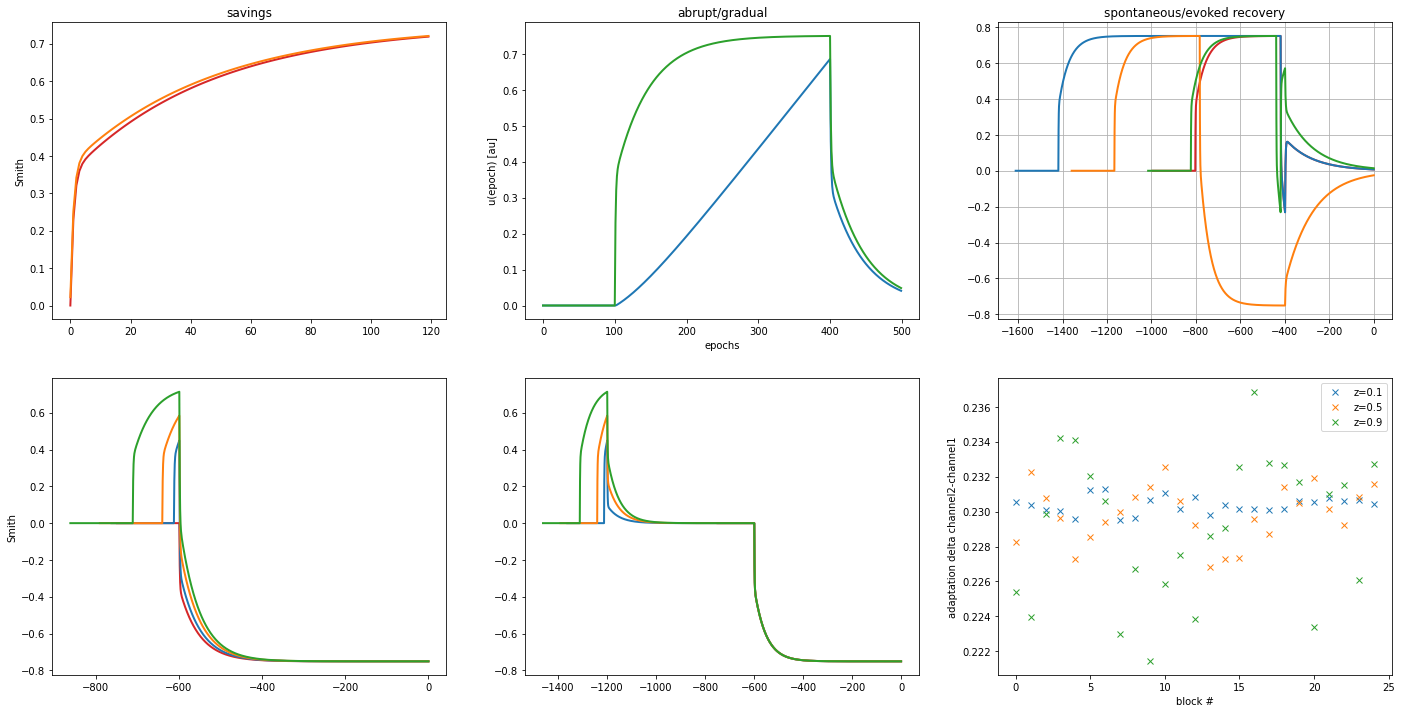

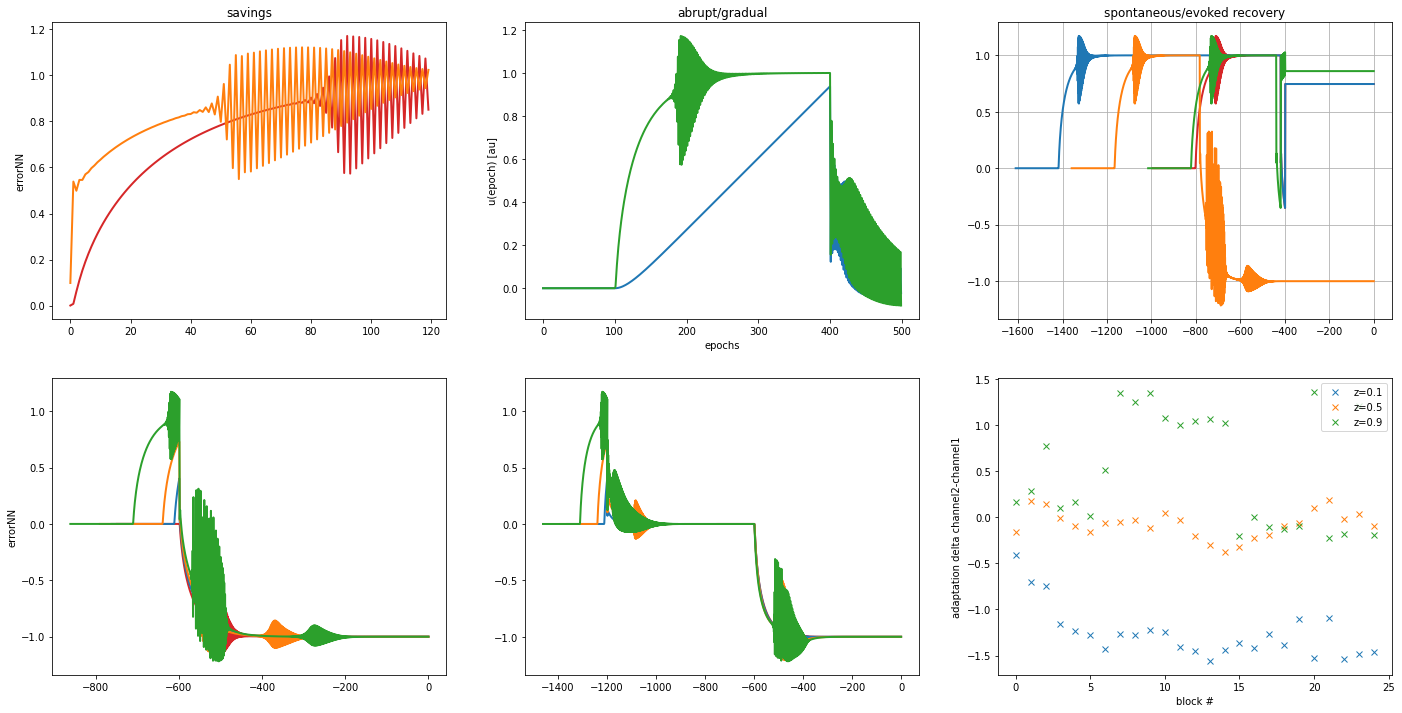

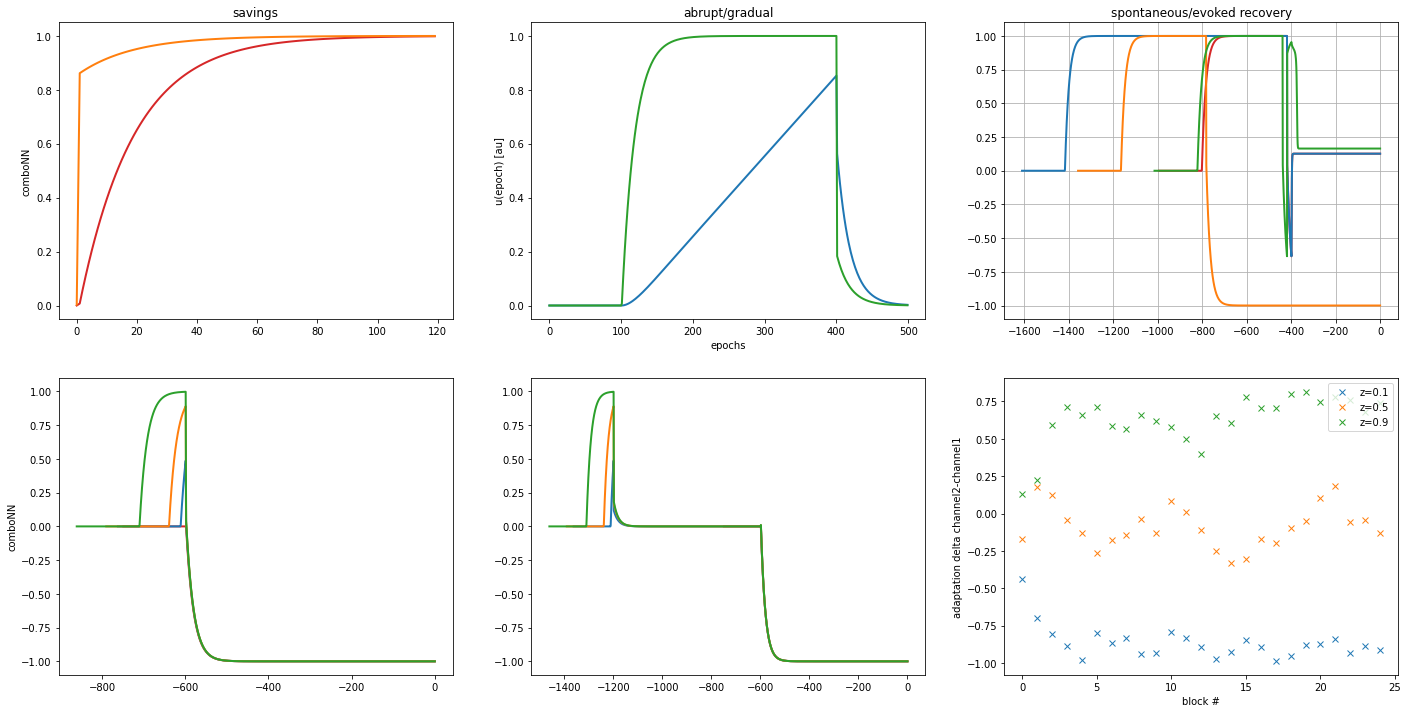

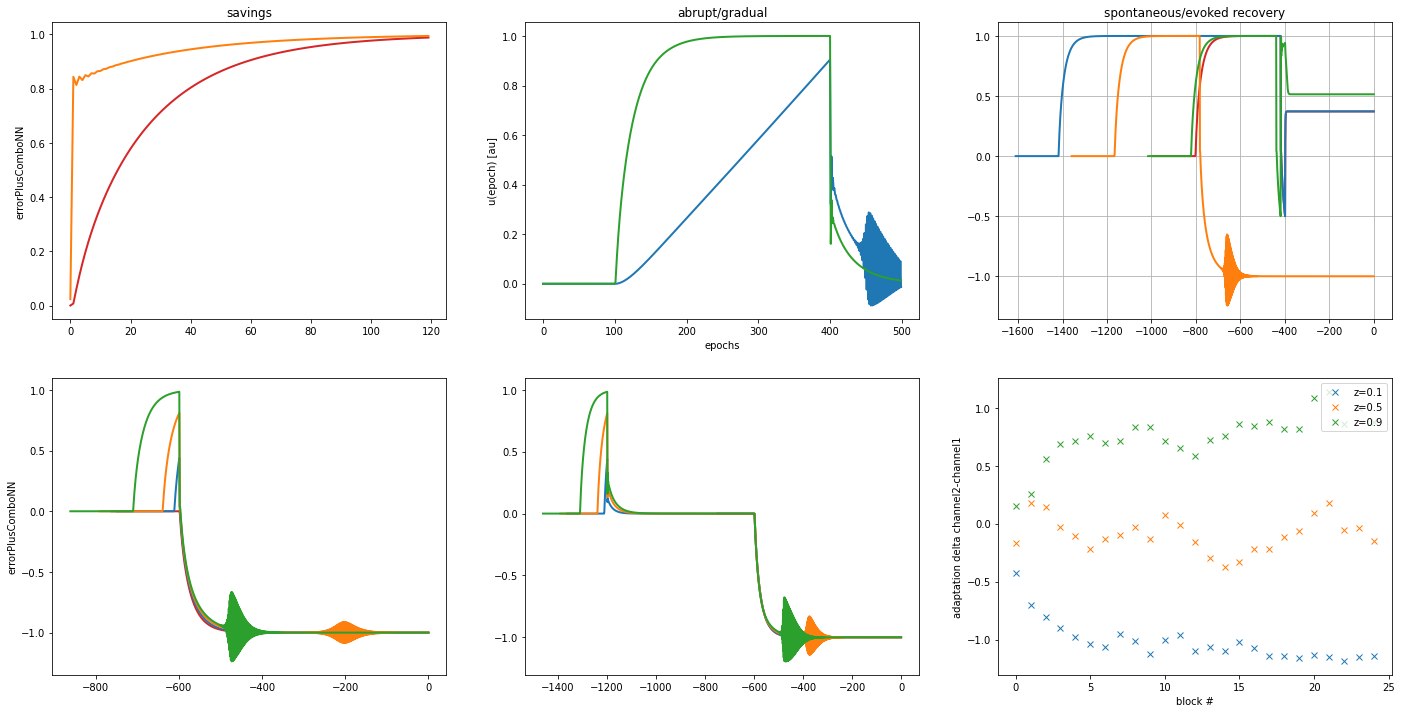

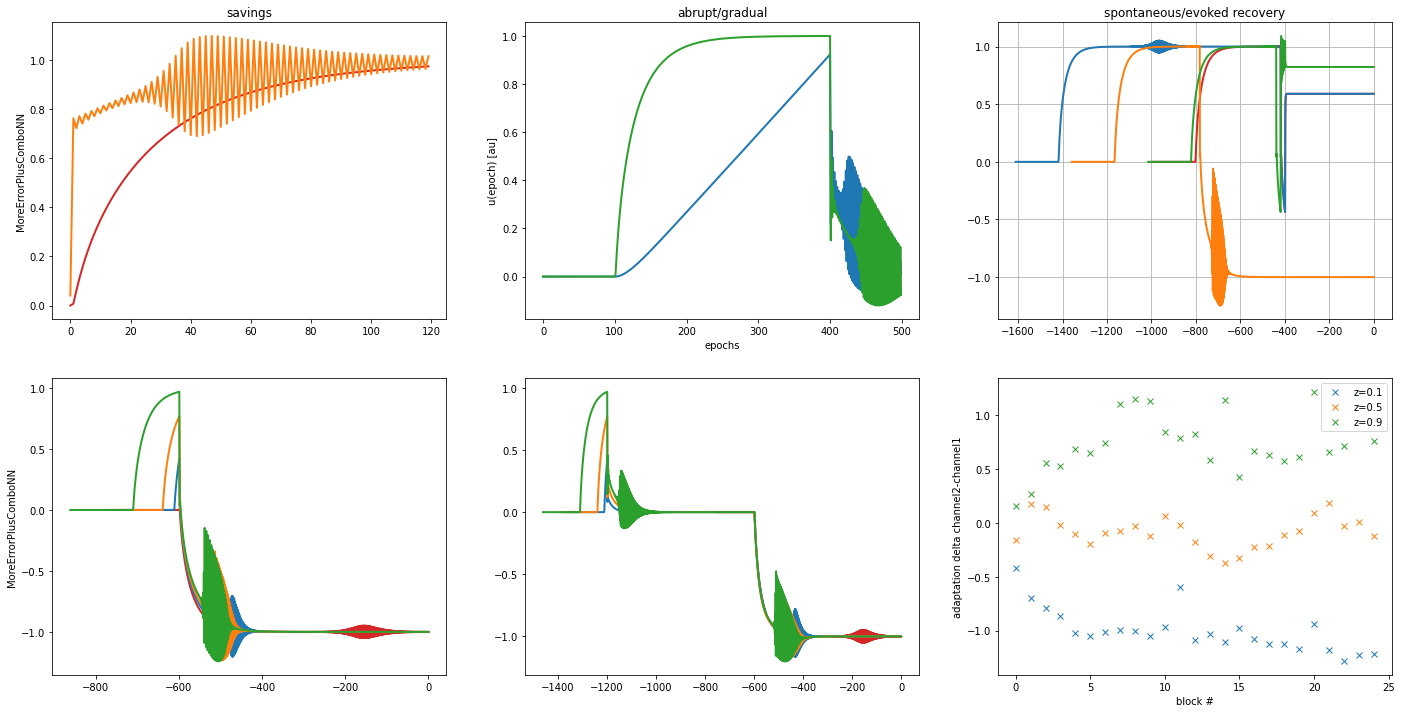

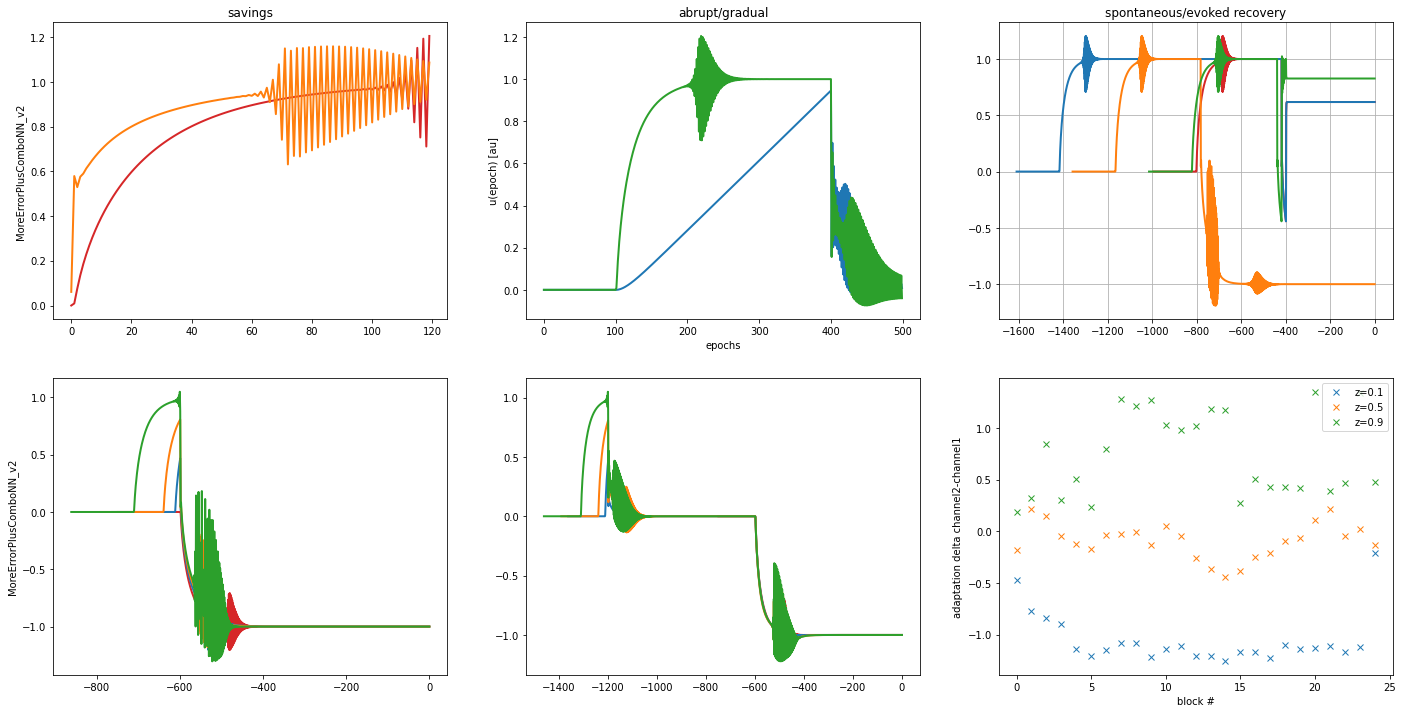

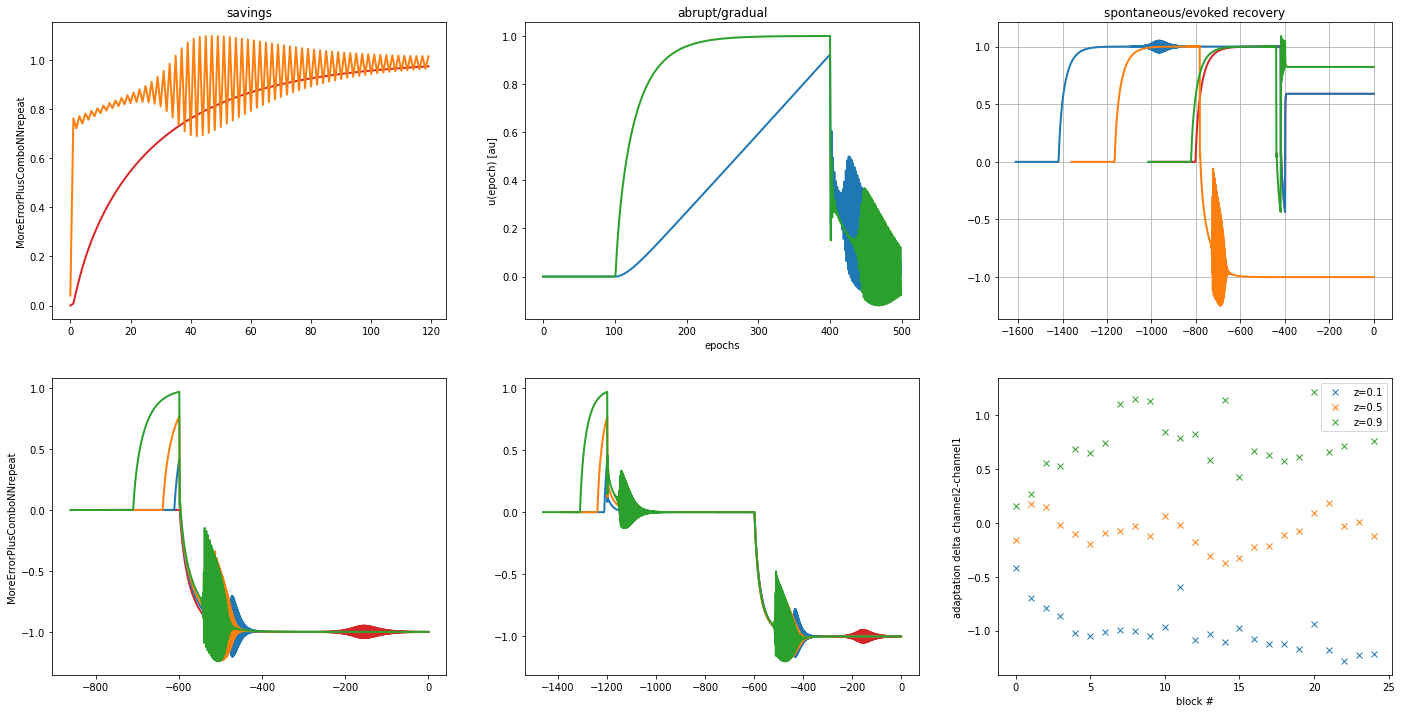

In [29]:
for name, these_results in results.items():
    do_plots(these_results,playlist)
    plt.subplot(2,3,1)
    plt.title(f'savings')
    plt.ylabel(name)
    plt.subplot(2,3,2)
    plt.title(f'abrupt/gradual')
    plt.subplot(2,3,3)
    plt.title(f'spontaneous/evoked recovery')
    plt.grid(True)
    plt.subplot(2,3,4)
    plt.ylabel(name)
    plt.show()

In [31]:
ww=4
smoothed_results = {}
for i in results:
    smoothed_results[i] = {}
    for k,v in results[i].items():
        smoothed_results[i][k] = SimpleNamespace()
        smoothed_results[i][k].u_lp = np.convolve(np.ones(ww)/ww, v.u_lp)

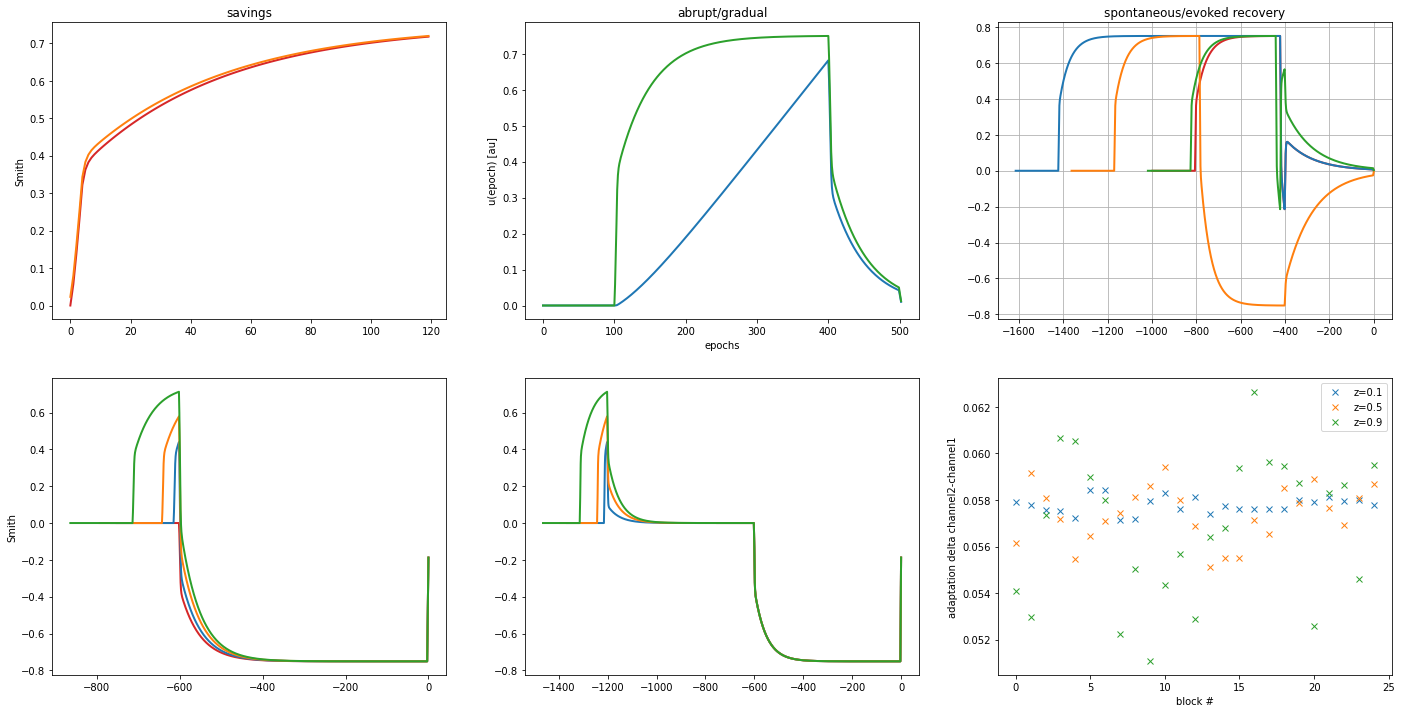

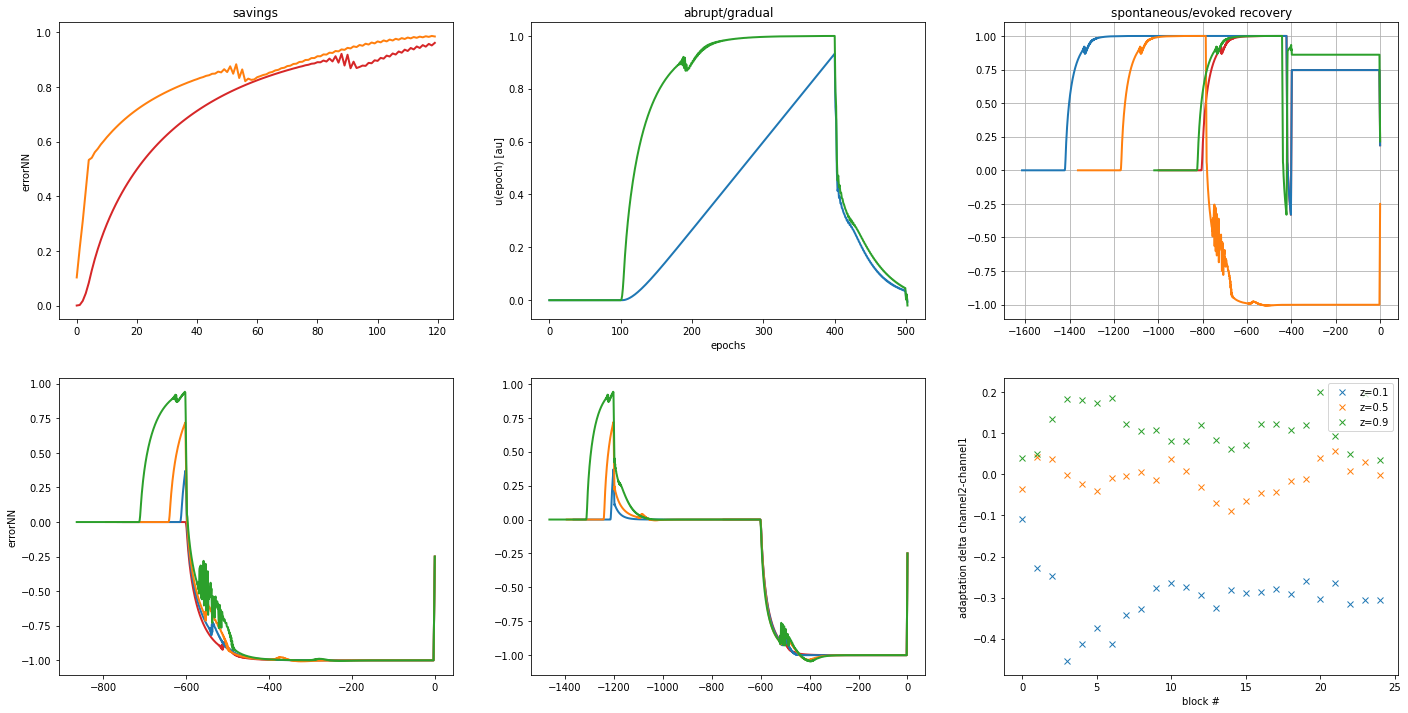

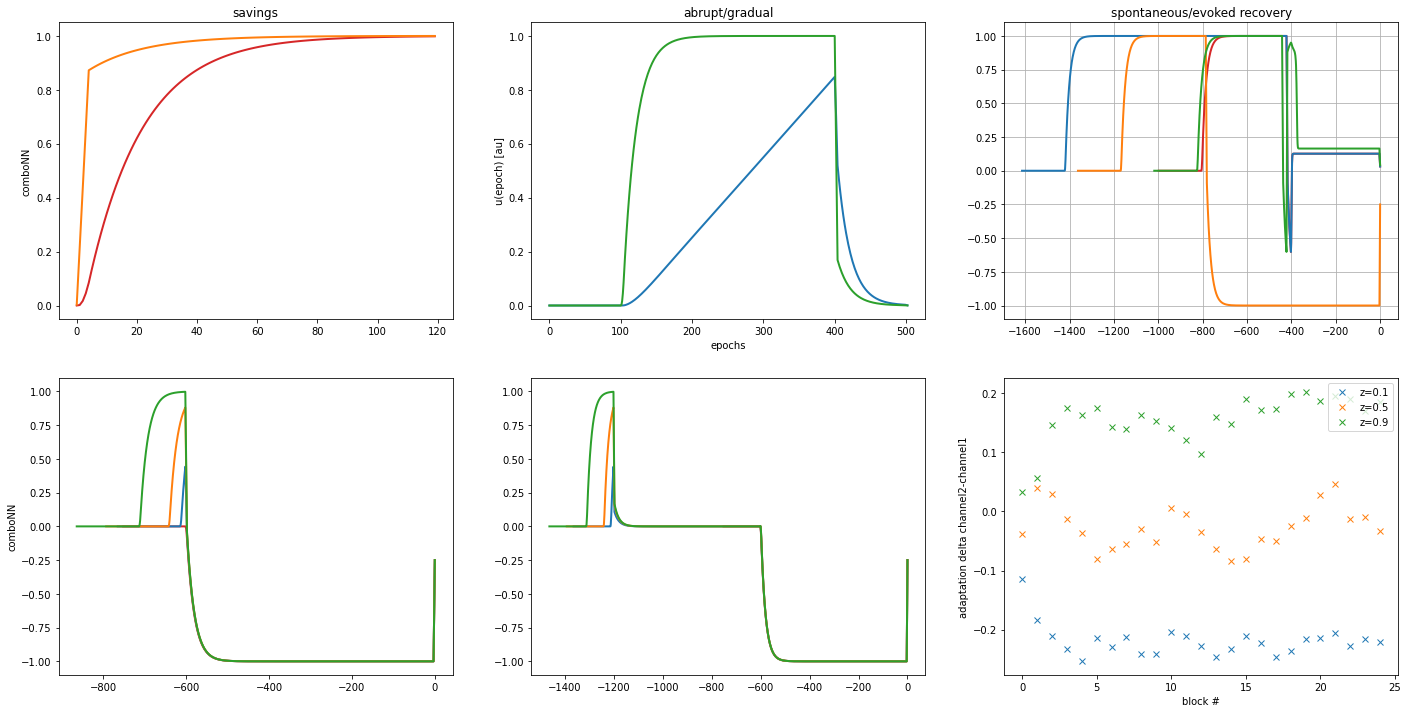

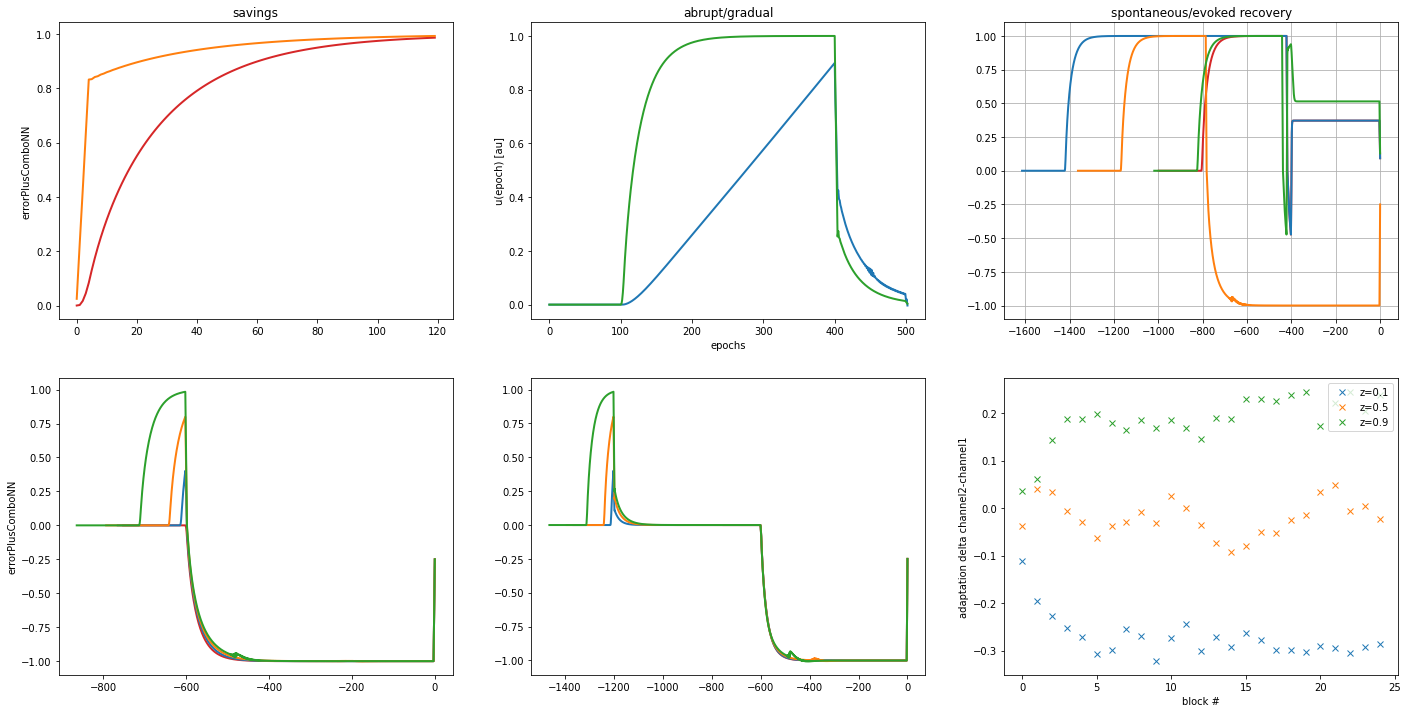

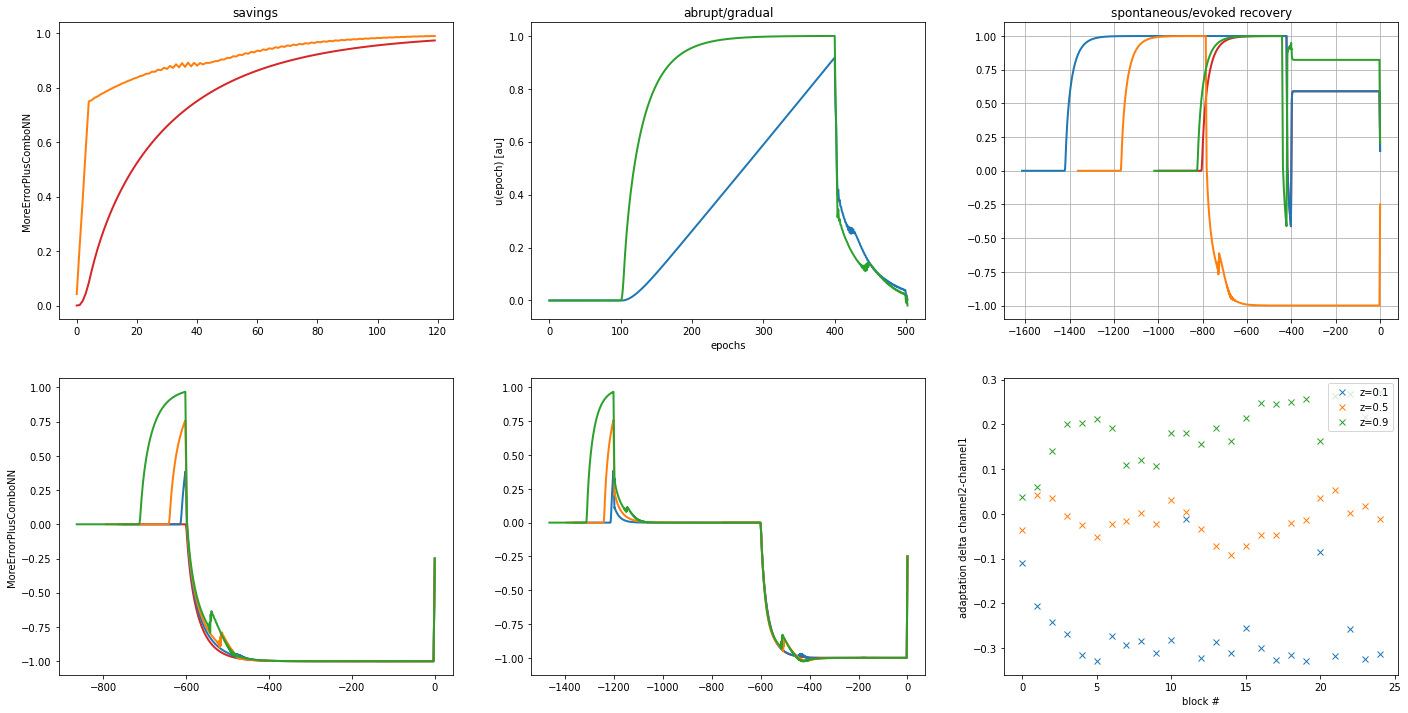

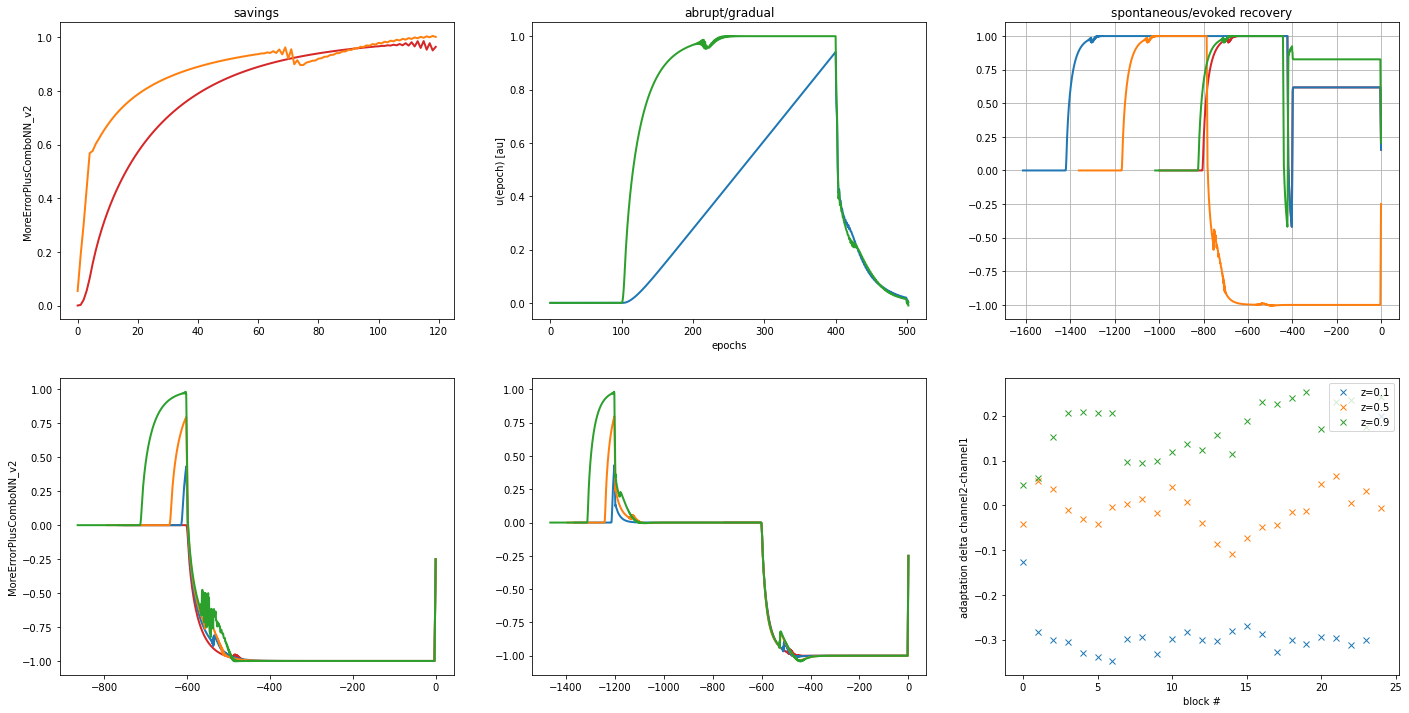

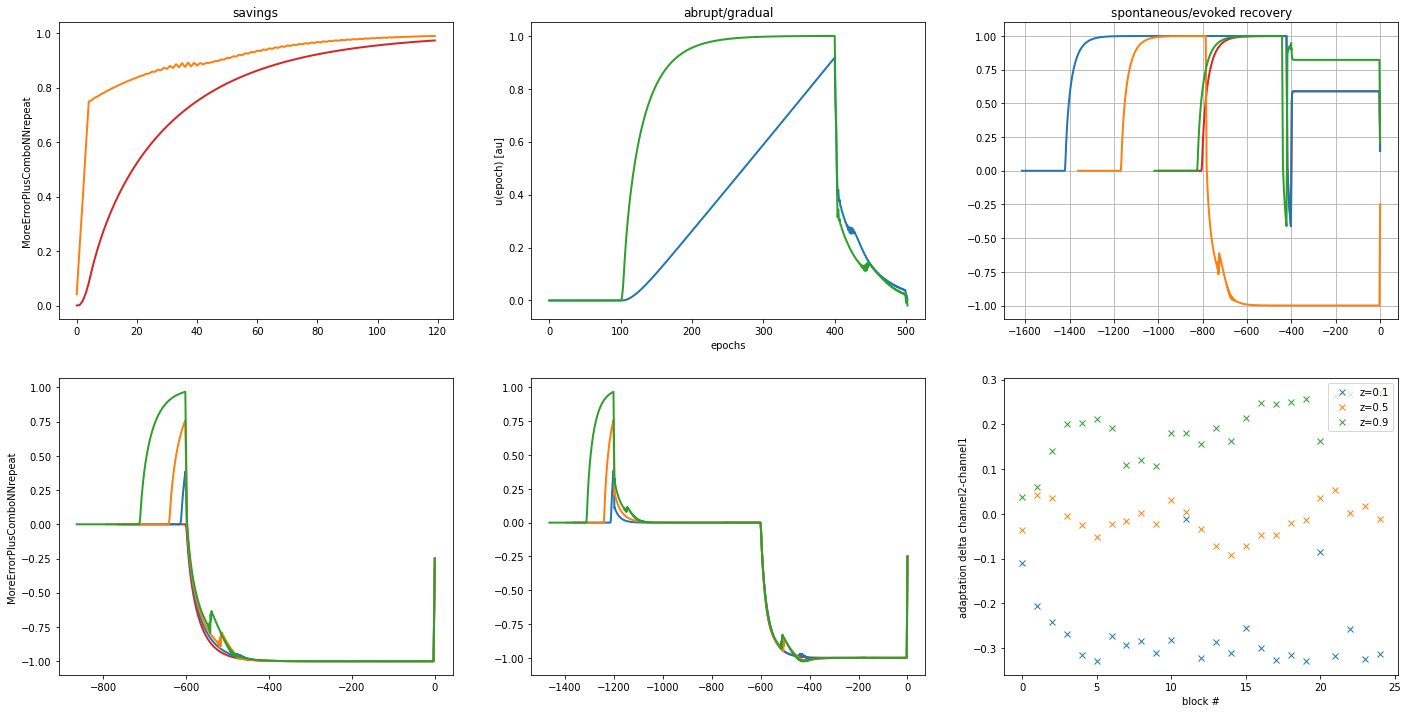

In [32]:
for name, these_results in smoothed_results.items():
    do_plots(these_results,playlist)
    plt.subplot(2,3,1)
    plt.title(f'savings')
    plt.ylabel(name)
    plt.subplot(2,3,2)
    plt.title(f'abrupt/gradual')
    plt.subplot(2,3,3)
    plt.title(f'spontaneous/evoked recovery')
    plt.grid(True)
    plt.subplot(2,3,4)
    plt.ylabel(name)
    plt.show()

# zooming into spontaneous recovery at time-intervals as in Smith paper

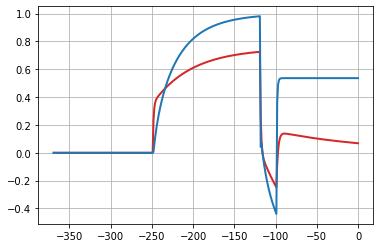

In [12]:
for ii, model_name in enumerate(['Smith','MoreErrorPlusComboNN']):
    plot_by_key(results[model_name],
                    ['sprecoverySMITH'],
                    colors=[antero_colors[ii]], # a hack to perserve our standard color codind
                    align_end=True,
                    visu_offsets=[0]*10,
                   )
plt.grid()
# plt.xlim([-1000,-300])

# Overlearning

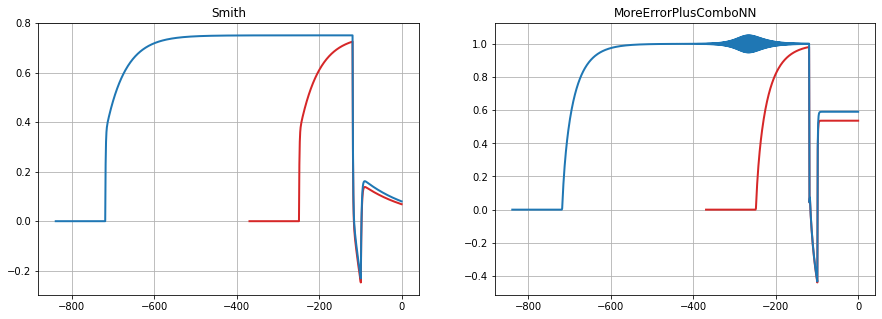

In [13]:
plt.figure(figsize=(15,5))

for ii, model_name in enumerate(['Smith','MoreErrorPlusComboNN']):
    plt.subplot(1,2,ii+1)
    plot_by_key(results[model_name],
                    ['sprecoverySMITH','spOVRrecoverySMITH'],
                    colors=antero_colors,
                    align_end=True,
                    visu_offsets=[0]*10,
                   )
    plt.title(model_name)
    plt.grid()

## Zoom into anterograde interference
We fist plot it with appropreate zoom, then replot on logarithmic scale to show constant convergence rate

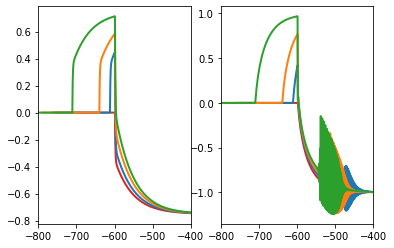

In [14]:
for ii, model_name in enumerate(['Smith','MoreErrorPlusComboNN']):
    plt.subplot(1,2,ii+1)
    plot_by_key(results[model_name],
                    ['AB0','AB1','AB2','AB3'],
                    colors=['tab:red','tab:blue','tab:orange','tab:green'],
                    align_end=True,
                    visu_offsets=[0]*10,
                   )
    plt.xlim([-800,-400])
# plt.ylim([-1,0])


/tmp/ipykernel_7274/1457782435.py:13: RuntimeWarning: invalid value encountered in log10
  plt.plot(x[300:600-1], np.diff(np.log10(y[300:600]-y[-1])),color=antero_colors[s])


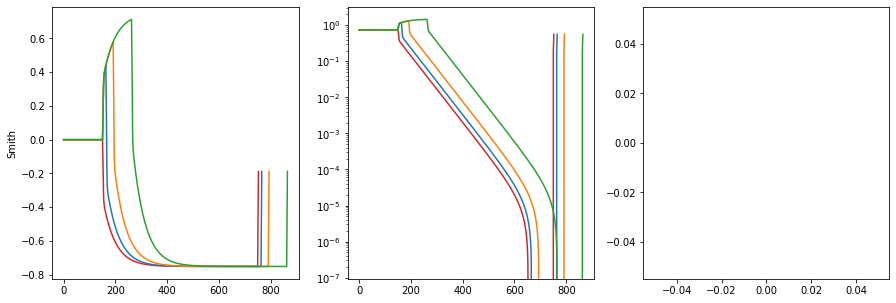

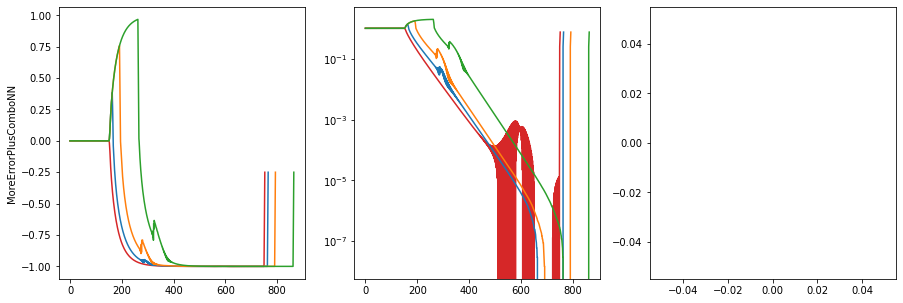

In [15]:
for ii, model_name in enumerate(['Smith','MoreErrorPlusComboNN']):
    these_results=smoothed_results[model_name]
    plt.figure(figsize=(15,5))
    for s, scenario in enumerate(['AB0','AB1','AB2','AB3']):
        y= these_results[scenario].u_lp
        x = np.arange(len(y))
        plt.subplot(1,3,1)
        plt.plot(x,y, color=antero_colors[s])
        plt.ylabel(model_name)
        plt.subplot(1,3,2)
        plt.semilogy(x,y-y[-100],color=antero_colors[s])
        plt.subplot(1,3,3)
        plt.plot(x[300:600-1], np.diff(np.log10(y[300:600]-y[-1])),color=antero_colors[s])

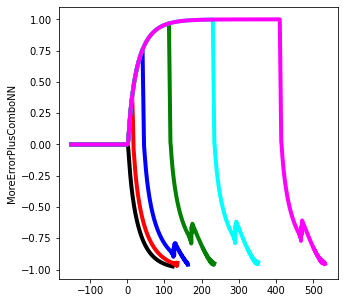

In [16]:
paper_colors = ['black','red', 'blue', 'green','cyan', 'magenta']
for ii, model_name in enumerate(['MoreErrorPlusComboNN']):
    these_results=smoothed_results[model_name]
    plt.figure(figsize=(5,5))
    for s, scenario in enumerate(['AB0','AB1','AB2','AB3','AB4','AB5']):
        y= these_results[scenario].u_lp
        x = np.arange(len(y)) -playlist['AB0'][0][1]
        bck_cut = playlist['AB0'][-1][1] - 120
#         plt.subplot(1,3,1)
        plt.plot(x[:-bck_cut],y[:-bck_cut], color=paper_colors[s],linewidth=4)
        plt.ylabel(model_name)
        plt.grid()
#         plt.xlim([0,500])
#         plt.subplot(1,3,2)
#         plt.semilogy(x,y-y[-100],color=antero_colors[s])
#         plt.subplot(1,3,3)
#         plt.plot(x[300:600-1], np.diff(np.log10(y[300:600]-y[-1])),color=antero_colors[s])

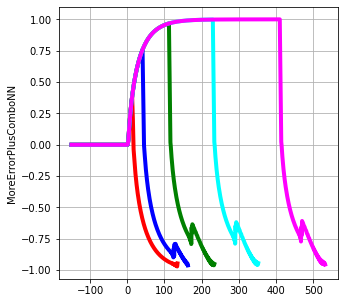

In [17]:
paper_colors = ['red', 'blue', 'green','cyan', 'magenta']
for ii, model_name in enumerate(['MoreErrorPlusComboNN']):
    these_results=smoothed_results[model_name]
    plt.figure(figsize=(5,5))
    for s, scenario in enumerate(['AB1','AB2','AB3','AB4','AB5']):
        y= these_results[scenario].u_lp
        x = np.arange(len(y)) -playlist['AB0'][0][1]
        bck_cut = playlist['AB0'][-1][1] - 120
#         plt.subplot(1,3,1)
        plt.plot(x[:-bck_cut],y[:-bck_cut], color=paper_colors[s],linewidth=4)
        plt.ylabel(model_name)
        plt.grid()

batata


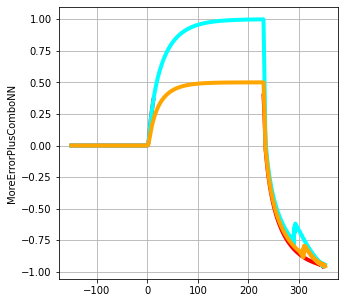

In [18]:
paper_colors = ['red','cyan', 'orange']
antero_interval = 120
for ii, model_name in enumerate(['MoreErrorPlusComboNN']):
    these_results=smoothed_results[model_name]
    plt.figure(figsize=(5,5))
    for s, scenario in enumerate(['AB1','AB4','AB4r']):
        y= these_results[scenario].u_lp
        x = np.arange(len(y)) -playlist['AB0'][0][1]
        bck_cut = playlist['AB0'][-1][1] - antero_interval
#         plt.subplot(1,3,1)
        if scenario == 'AB1':
            t_part1 =  playlist['AB1'][0][1] + playlist['AB1'][1][1]
            t_part1_4 =  playlist['AB4'][0][1] + playlist['AB4'][1][1]

#             t_part2 =  playlist['AB1'][0][1] + playlist['AB1'][1][1]antero_interval
            plt.plot(x[:t_part1],y[:t_part1], color=paper_colors[s],linewidth=4)
            plt.plot(x[t_part1_4:t_part1_4+antero_interval],0.01+y[t_part1:t_part1+antero_interval], color=paper_colors[s],linewidth=4)
            print('batata')
        else:
            plt.plot(x[:-bck_cut],y[:-bck_cut], color=paper_colors[s],linewidth=4)
        plt.ylabel(model_name)
        plt.grid()

In [19]:
playlist['AB1'][0][1], playlist['AB1'][1][1]

(150, 13)

/tmp/ipykernel_7274/1457782435.py:13: RuntimeWarning: invalid value encountered in log10
  plt.plot(x[300:600-1], np.diff(np.log10(y[300:600]-y[-1])),color=antero_colors[s])


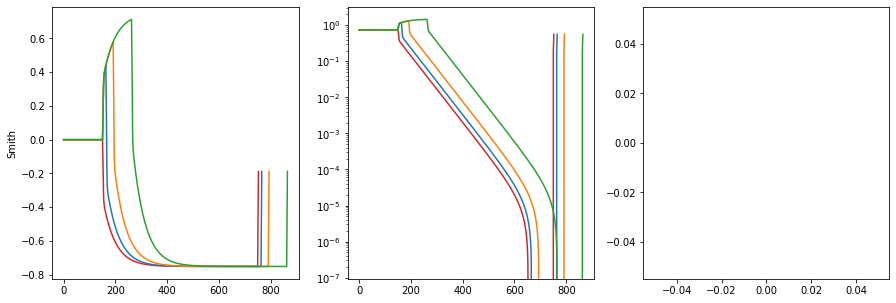

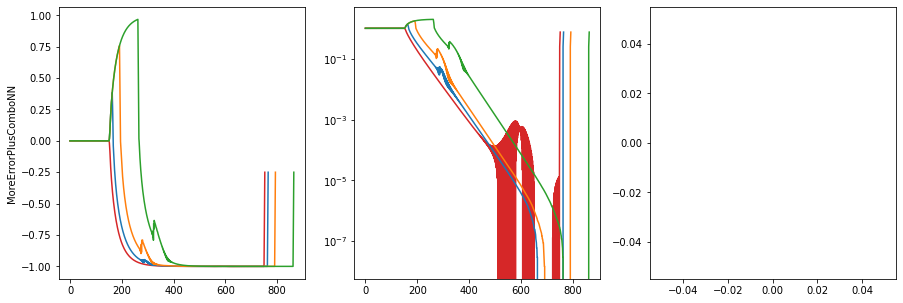

In [20]:
for ii, model_name in enumerate(['Smith','MoreErrorPlusComboNN']):
    these_results=smoothed_results[model_name]
    plt.figure(figsize=(15,5))
    for s, scenario in enumerate(['AB0','AB1','AB2','AB3']):
        y= these_results[scenario].u_lp
        x = np.arange(len(y))
        plt.subplot(1,3,1)
        plt.plot(x,y, color=antero_colors[s])
        plt.ylabel(model_name)
        plt.subplot(1,3,2)
        plt.semilogy(x,y-y[-100],color=antero_colors[s])
        plt.subplot(1,3,3)
        plt.plot(x[300:600-1], np.diff(np.log10(y[300:600]-y[-1])),color=antero_colors[s])

# Ensuring that boiling-frog effect does not show up for longer adaptations 

In [21]:
plt.figure(figsize=(18,9))
for rr, (name, these_results) in enumerate(frog_results.items()):
    for f in range(3):
        plt.subplot(3,3,3*rr+f+1)
        plot_by_key(these_results, [f'frogs{f}',f'anti_frogs{f}'],visu_offsets = [0, 0.00])
        plt.xlabel('epochs')
        plt.ylabel('u(epoch) [au]')

NameError: name 'frog_results' is not defined

<Figure size 1296x648 with 0 Axes>

In [ ]:
for ii, model_name in enumerate(['Smith','someNN']):
    these_results=results[model_name]
    plt.figure(figsize=(15,5))
    for s, scenario in enumerate(['savings']):
        y= these_results[scenario].u_lp
        x = np.arange(len(y))
#         plt.subplot(1,3,1)
        plt.plot(x,y, color=antero_colors[s])
        plt.plot(x,y,'x', color=antero_colors[s])
        plt.ylabel(model_name)


In [ ]:
len({})